In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lifelines.utils import concordance_index
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import matplotlib.ticker as mticker
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

In [3]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [4]:
# define three-year mortalitty status
df_train.loc[:,'MORTSTAT3Y'] = np.where((df_train["MORTSTAT"] == 1) & (df_train["TIMETOEVENT"] <= 3), 1, 0)
df_test.loc[:,'MORTSTAT3Y'] = np.where((df_test["MORTSTAT"] == 1) & (df_test["TIMETOEVENT"] <= 3), 1, 0)

In [5]:
# select features and target
X_train_3y = df_train.drop(columns=['MORTSTAT3Y', 'TIMETOEVENT', 'MORTSTAT'])
y_train_3y = df_train['MORTSTAT3Y']

X_test_3y = df_test.drop(columns=['MORTSTAT3Y', 'TIMETOEVENT', 'MORTSTAT'])
y_test_3y = df_test['MORTSTAT3Y']

In [6]:
# XGBC

In [7]:
xgbc = XGBClassifier(objective='binary:logistic', random_state=42, 
                        n_estimators=200, learning_rate=0.05, subsample=0.5, colsample_bytree=0.8, max_depth=3)

# train
xgbc.fit(X_train_3y, y_train_3y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
g_x_train = xgbc.predict_proba(X_train_3y)[:, 1]
g_x_test = xgbc.predict_proba(X_test_3y)[:, 1]

In [9]:
# CALIBRATION 10

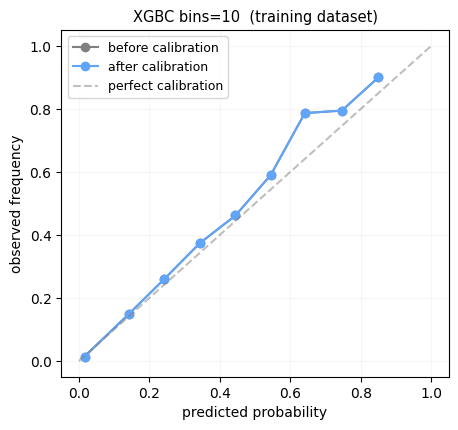

In [10]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_train, prob_pred_train = calibration_curve(y_train_3y, g_x_train, n_bins=10, strategy='uniform')

# Step 2: Fit isotonic regression (PREDICTED → OBSERVED)
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(prob_pred_train, prob_true_train)

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_train, prob_true_train, marker='o', label="before calibration", color="gray")
plt.plot(prob_pred_train, iso_reg.predict(prob_pred_train), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=10  (training dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_train_10.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

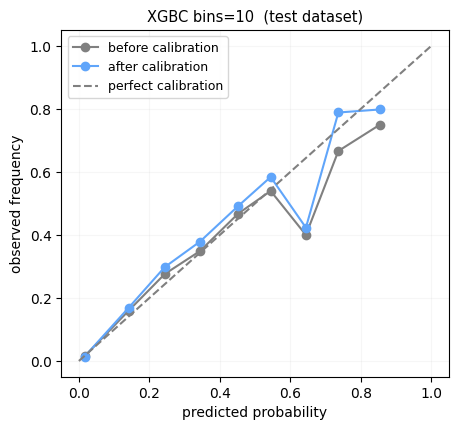

In [11]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_test, prob_pred_test = calibration_curve(y_test_3y, g_x_test, n_bins=10, strategy='uniform')

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_test, prob_true_test, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_test, iso_reg.predict(prob_true_test), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration")
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=10  (test dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_test_10.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# log-loss
log_loss_3y_train = log_loss(y_train_3y, iso_reg.predict(g_x_train))
log_loss_3y_test = log_loss(y_test_3y, iso_reg.predict(g_x_test))

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, iso_reg.predict(g_x_train))
bs_test_3y = brier_score_loss(y_test_3y, iso_reg.predict(g_x_test))

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')

Log Loss is: 0.1117
Log Loss os: 0.1132
BS is: 0.0286
BS os: 0.0292


In [13]:
# CALIBRATION 20

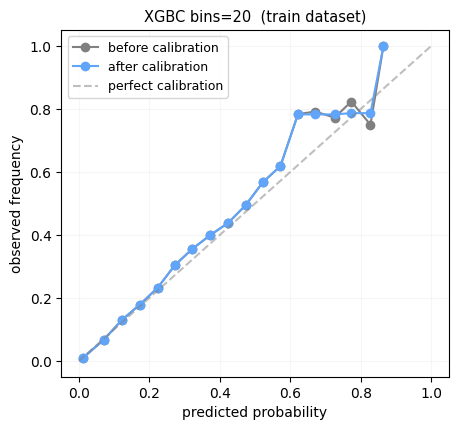

In [14]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_train, prob_pred_train = calibration_curve(y_train_3y, g_x_train, n_bins=20, strategy='uniform')

# Step 2: Fit isotonic regression (PREDICTED → OBSERVED)
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(prob_pred_train, prob_true_train)

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_train, prob_true_train, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_train, iso_reg.predict(prob_pred_train), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=20  (train dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_train_20.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

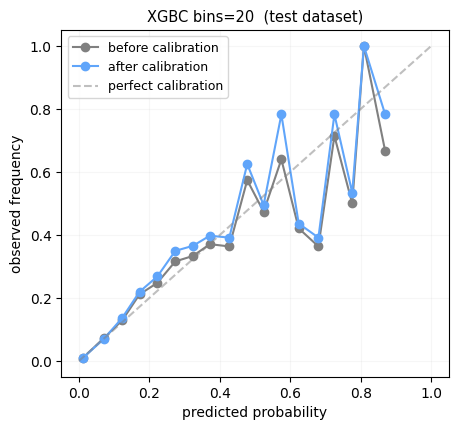

In [15]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_test, prob_pred_test = calibration_curve(y_test_3y, g_x_test, n_bins=20, strategy='uniform')

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_test, prob_true_test, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_test, iso_reg.predict(prob_true_test), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=20  (test dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_test_20.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# log-loss
log_loss_3y_train = log_loss(y_train_3y, iso_reg.predict(g_x_train))
log_loss_3y_test = log_loss(y_test_3y, iso_reg.predict(g_x_test))

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, iso_reg.predict(g_x_train))
bs_test_3y = brier_score_loss(y_test_3y, iso_reg.predict(g_x_test))

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')

Log Loss is: 0.1095
Log Loss os: 0.1127
BS is: 0.0285
BS os: 0.0292


In [17]:
# CALIBRATION 30

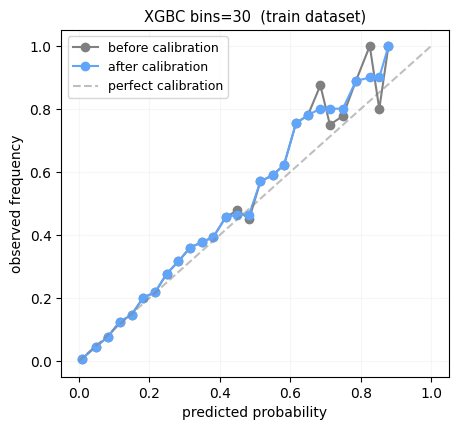

In [18]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_train, prob_pred_train = calibration_curve(y_train_3y, g_x_train, n_bins=30, strategy='uniform')

# Step 2: Fit isotonic regression (PREDICTED → OBSERVED)
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(prob_pred_train, prob_true_train)

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_train, prob_true_train, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_train, iso_reg.predict(prob_pred_train), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=30  (train dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_train_30.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

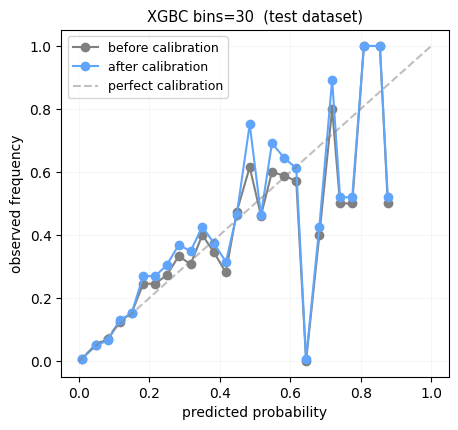

In [19]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_test, prob_pred_test = calibration_curve(y_test_3y, g_x_test, n_bins=30, strategy='uniform')

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_test, prob_true_test, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_test, iso_reg.predict(prob_true_test), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=30  (test dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_test_30.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# log-loss
log_loss_3y_train = log_loss(y_train_3y, iso_reg.predict(g_x_train))
log_loss_3y_test = log_loss(y_test_3y, iso_reg.predict(g_x_test))

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, iso_reg.predict(g_x_train))
bs_test_3y = brier_score_loss(y_test_3y, iso_reg.predict(g_x_test))

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')

Log Loss is: 0.1087
Log Loss os: 0.1105
BS is: 0.0285
BS os: 0.0292


In [21]:
# CALIBRATION 50

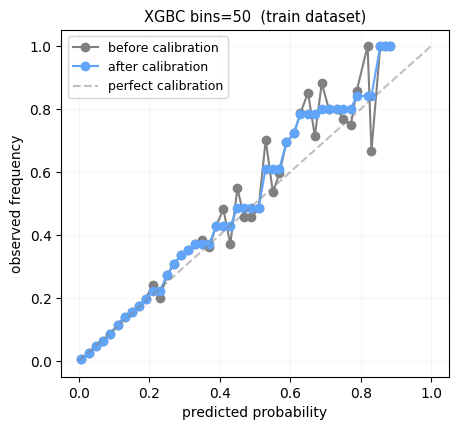

In [22]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_train, prob_pred_train = calibration_curve(y_train_3y, g_x_train, n_bins=50, strategy='uniform')

# Step 2: Fit isotonic regression (PREDICTED → OBSERVED)
iso_reg = IsotonicRegression(out_of_bounds="clip")
iso_reg.fit(prob_pred_train, prob_true_train)

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_train, prob_true_train, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_train, iso_reg.predict(prob_pred_train), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability")
plt.ylabel("observed frequency")
plt.title("XGBC bins=50  (train dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_train_50.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

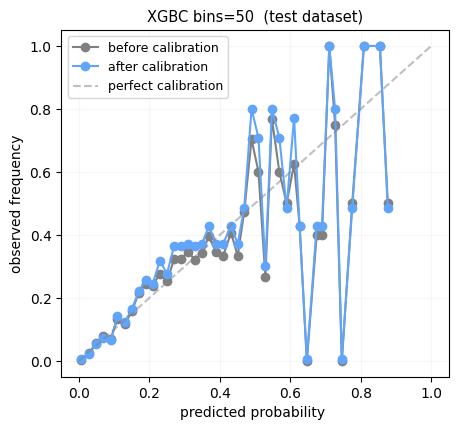

In [23]:
# Step 1: Calibration curve (binning predicted probs)
prob_true_test, prob_pred_test = calibration_curve(y_test_3y, g_x_test, n_bins=50, strategy='uniform')

# Step 4: Plot calibration before/after
plt.figure(figsize=(5, 4.5))
plt.plot(prob_pred_test, prob_true_test, marker='o', label="before calibration", color='gray')
plt.plot(prob_pred_test, iso_reg.predict(prob_true_test), marker='o', label="after calibration", color='#60A5FA')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label="perfect calibration", alpha=0.5)
plt.xlabel("predicted probability ")
plt.ylabel("observed frequency")
plt.title("XGBC bins=50  (test dataset)", fontsize=10.5)
plt.legend(fontsize=9)
plt.grid(alpha=0.1)
plt.savefig('xgbc_test_50.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
# log-loss
log_loss_3y_train = log_loss(y_train_3y, iso_reg.predict(g_x_train))
log_loss_3y_test = log_loss(y_test_3y, iso_reg.predict(g_x_test))

# compute Brier
bs_train_3y = brier_score_loss(y_train_3y, iso_reg.predict(g_x_train))
bs_test_3y = brier_score_loss(y_test_3y, iso_reg.predict(g_x_test))

print(f'Log Loss is: {log_loss_3y_train:.4f}')
print(f'Log Loss os: {log_loss_3y_test:.4f}')
print(f'BS is: {bs_train_3y:.4f}')
print(f'BS os: {bs_test_3y:.4f}')

Log Loss is: 0.1081
Log Loss os: 0.1115
BS is: 0.0285
BS os: 0.0292
